In [15]:

import numpy as np             
import math
import regions                                   
import pylab                                
import matplotlib                           
import matplotlib.gridspec as gridspec      
                                           
                                           
import scipy

import astropy.io.fits as fits             
                                           
from astropy.wcs import WCS                 
from astropy import units as u              

import pyspeckit as psk                     
                                            
                                           
from spectral_cube import SpectralCube     

from reproject import reproject_interp     
from reproject.mosaicking import find_optimal_celestial_wcs 


                                            
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

                                            
%matplotlib inline                             

matplotlib.rc('font', family='sans-serif')  
matplotlib.rc('text', usetex=True)      





## For  1 cube

SpectralCube with shape=(1917, 288, 288) and unit=Jy / beam:
 n_x:    288  type_x: RA---SIN  unit_x: deg    range:   266.572800 deg:  266.603675 deg
 n_y:    288  type_y: DEC--SIN  unit_y: deg    range:   -28.608259 deg:  -28.581154 deg
 n_s:   1917  type_s: VRAD      unit_s: km / s  range:     -318.379 km / s:     317.956 km / s


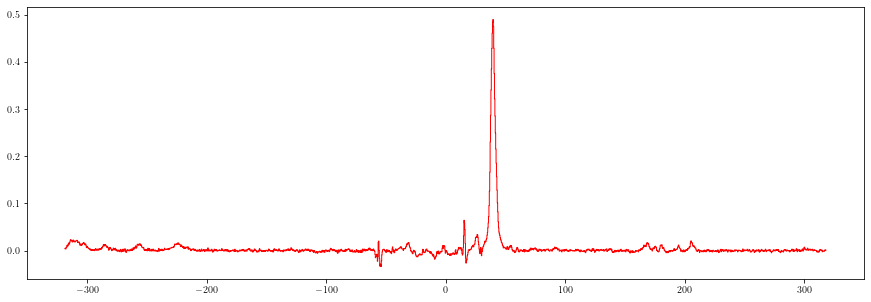

In [71]:
#reading in file
path="A.Dust_Ridge_13C16O.cube.I.pbcor.fits"
sc=SpectralCube.read(path)
sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") #change Hz-km/s
print(sc_kms)

#initializing variables
vel,Dec,Ra = sc_kms.world[:,0,0] 
z,x,y=pylab.where(sc_kms.hdu.data==np.nanmax(sc_kms.hdu.data))
subcube=sc_kms.hdu.data[:,int(x)-10:int(x)+10,int(y)-10:int(y)+10]
spectrum = np.average(subcube,axis=(1,2)) 

#plot figure
fig1=pylab.figure(1,figsize=(15,5))
ax1=pylab.subplot()
ax1.plot(vel,spectrum,lw=1,drawstyle='steps-mid',color="Red")


## For all 8 cubes

Text(0.02, 0.5, 'Intensity (Jy/Beam)')

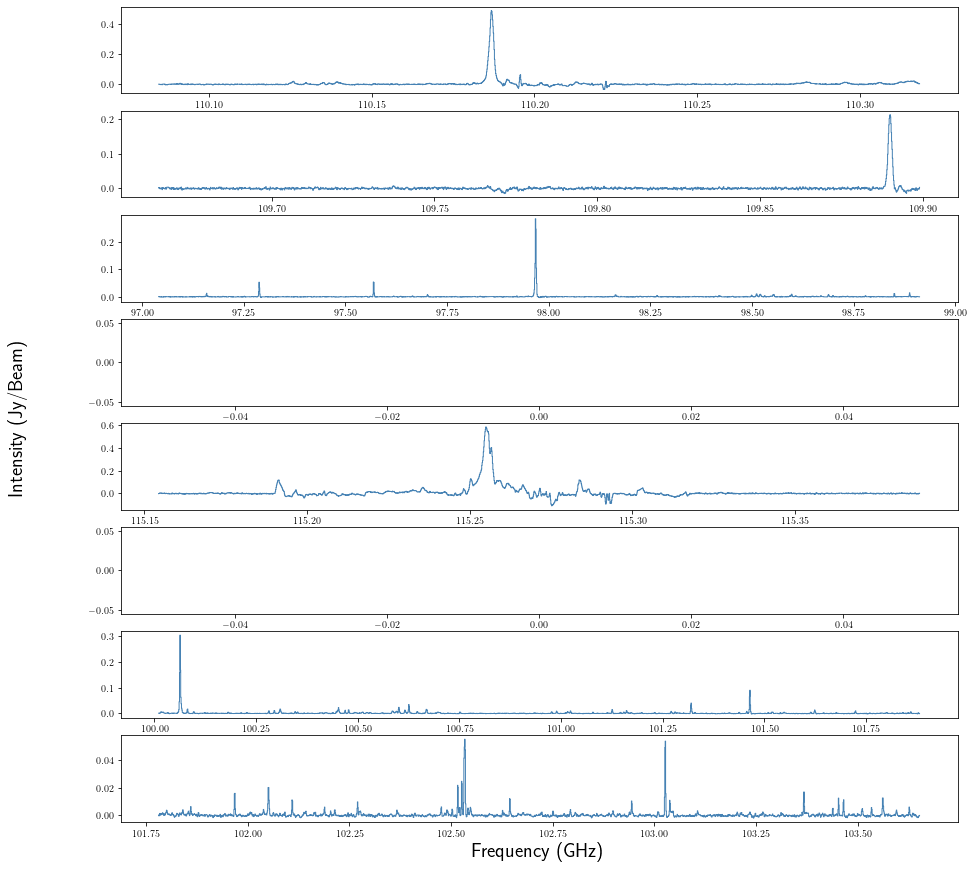

In [186]:
#reading in file, creating lists
paths=pylab.array(["A.Dust_Ridge_13C16O.cube.I.pbcor.fits","A.Dust_Ridge_12C18O.cube.I.pbcor.fits",
      "A.Dust_Ridge_sci.spw29.cube.I.pbcor.fits","A.Dust_Ridge_sci.spw31.cube.I.pbcor.fits",
     "B.Dust_Ridge_12C16O_1-0.cube.I.pbcor.fits","B.Dust_Ridge_12C17O.cube.I.pbcor.fits",
     "B.Dust_Ridge_sci.spw29.cube.I.pbcor.fits","B.Dust_Ridge_sci.spw31.cube.I.pbcor.fits"])

fig1=pylab.figure(1,figsize=(15,15))

for i,path in enumerate(paths):
    sc=SpectralCube.read(path)
    sc_Ghz = sc.with_spectral_unit(u.Hz*10**9) #change Hz-km/s
    vel,Dec,Ra = sc_Ghz.world[:,0,0] 
    z,x,y=pylab.where(sc_Ghz.hdu.data==np.nanmax(sc_Ghz.hdu.data))
    subcube=sc_Ghz.hdu.data[:,int(x)-10:int(x)+10,int(y)-10:int(y)+10]
    spectrum = np.average(subcube,axis=(1,2)) 
    ax1=pylab.subplot(8,1,i+1)
    ax1.plot(vel,spectrum,lw=1,drawstyle='steps-mid',color="SteelBlue")
    pylab.xlabel("Frequency (GHz)", fontsize=20)
    
fig1.supylabel('Intensity (Jy/Beam)',fontsize=20)


## Convert to K

In [9]:
names_sc=['sc_13C16O', 'sc_12C18O', 'sc_A_sci.spw29', 'sc_A_sci.spw31', 'sc_12C16O', 'sc_12C17O', 'sc_B_sci.spw29', 'sc_B_sci.spw31']
paths=pylab.array(["A.Dust_Ridge_13C16O.cube.I.pbcor.fits","A.Dust_Ridge_12C18O.cube.I.pbcor.fits",
      "A.Dust_Ridge_sci.spw29.cube.I.pbcor.fits","A.Dust_Ridge_sci.spw31.cube.I.pbcor.fits",
     "B.Dust_Ridge_12C16O_1-0.cube.I.pbcor.fits","B.Dust_Ridge_12C17O.cube.I.pbcor.fits",
     "B.Dust_Ridge_sci.spw29.cube.I.pbcor.fits","B.Dust_Ridge_sci.spw31.cube.I.pbcor.fits"])
for i, path in enumerate(paths):
    sc=SpectralCube.read(path)
    sc.allow_huge_operations=True 
    names_sc[i] = sc.to(u.K)
    print(names_sc[i])

SpectralCube with shape=(1917, 288, 288) and unit=K:
 n_x:    288  type_x: RA---SIN  unit_x: deg    range:   266.572800 deg:  266.603675 deg
 n_y:    288  type_y: DEC--SIN  unit_y: deg    range:   -28.608259 deg:  -28.581154 deg
 n_s:   1917  type_s: FREQ      unit_s: Hz     range: 110084475871.000 Hz:110318387587.270 Hz
SpectralCube with shape=(1916, 288, 288) and unit=K:
 n_x:    288  type_x: RA---SIN  unit_x: deg    range:   266.572800 deg:  266.603675 deg
 n_y:    288  type_y: DEC--SIN  unit_y: deg    range:   -28.608259 deg:  -28.581154 deg
 n_s:   1916  type_s: FREQ      unit_s: Hz     range: 109665289848.000 Hz:109899079421.067 Hz
SpectralCube with shape=(1917, 288, 288) and unit=K:
 n_x:    288  type_x: RA---SIN  unit_x: deg    range:   266.572800 deg:  266.603675 deg
 n_y:    288  type_y: DEC--SIN  unit_y: deg    range:   -28.608259 deg:  -28.581154 deg
 n_s:   1917  type_s: FREQ      unit_s: Hz     range: 97041167474.300 Hz:98912349230.171 Hz
SpectralCube with shape=(1916, 28

## All 8 cubes cropped

conversion done


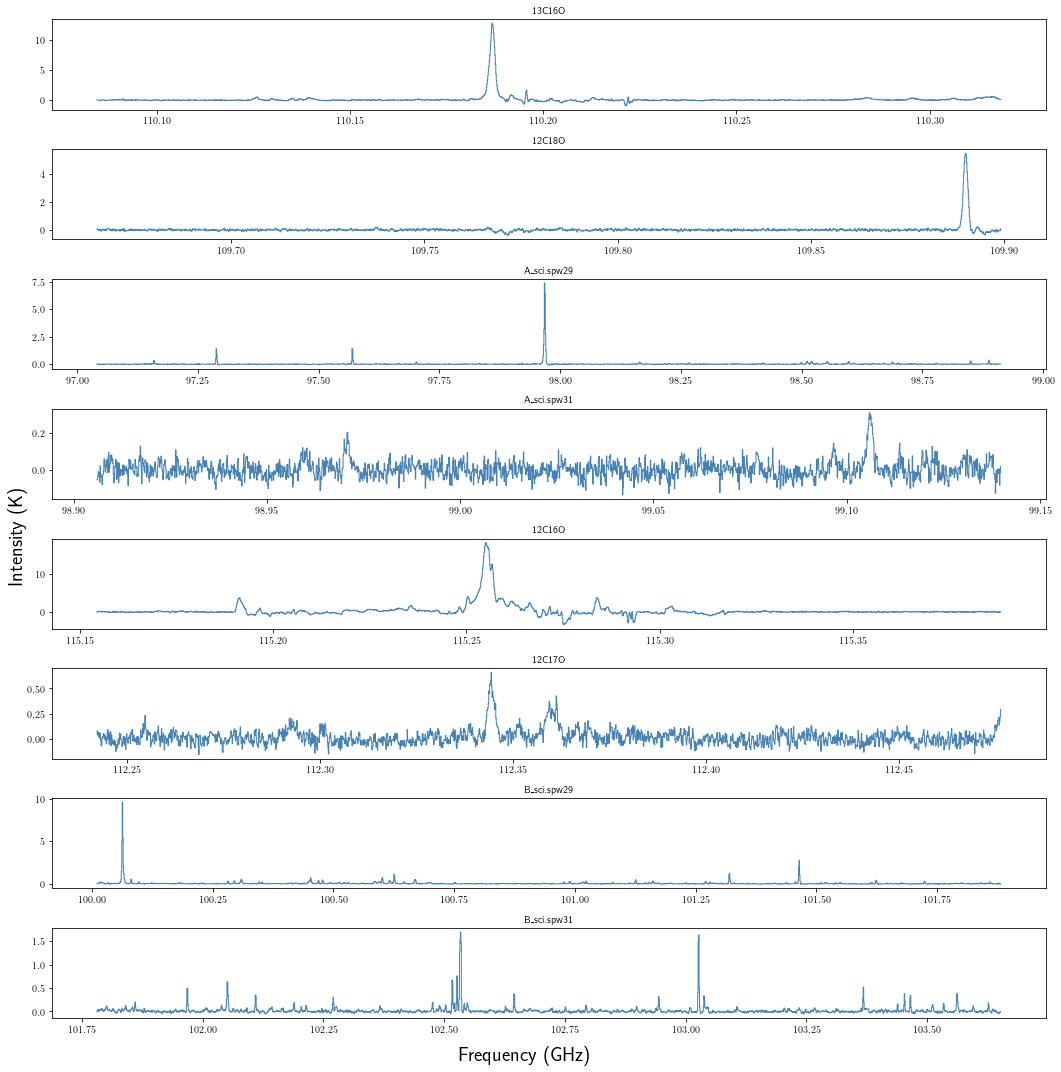

In [30]:
## I would also like to set a consistent scale for the y-axis

fig1=pylab.figure(1,figsize=(15,15))
names_sc=['sc_13C16O', 'sc_12C18O', 'sc_A_sci.spw29', 'sc_A_sci.spw31', 'sc_12C16O', 'sc_12C17O', 'sc_B_sci.spw29', 'sc_B_sci.spw31']
names=['13C16O', '12C18O', 'A_sci.spw29', 'A_sci.spw31', '12C16O', '12C17O', 'B_sci.spw29', 'B_sci.spw31']
paths=pylab.array(["A.Dust_Ridge_13C16O.cube.I.pbcor.fits","A.Dust_Ridge_12C18O.cube.I.pbcor.fits",
      "A.Dust_Ridge_sci.spw29.cube.I.pbcor.fits","A.Dust_Ridge_sci.spw31.cube.I.pbcor.fits",
     "B.Dust_Ridge_12C16O_1-0.cube.I.pbcor.fits","B.Dust_Ridge_12C17O.cube.I.pbcor.fits",
     "B.Dust_Ridge_sci.spw29.cube.I.pbcor.fits","B.Dust_Ridge_sci.spw31.cube.I.pbcor.fits"])
for i, path in enumerate(paths):
    sc=SpectralCube.read(path)
    sc.allow_huge_operations=True 
    names_sc[i] = sc.to(u.K)
    names_sc[i]=names_sc[i].with_spectral_unit(u.Hz*10**9) #change Hz-km/s
print("conversion done")
for i,path in enumerate(names_sc):
    vel,Dec,Ra = names_sc[i].world[:,0,0] 
    with fits.open(paths[i]) as hdul:
        size=hdul[0].header['NAXIS1']
    size=str(math.floor(size*0.5))
    region_str = "circle[["+size+"pix, "+size+"pix], 100pix], ICRS" 
    #cropped down to 100pix because full image wouldn't produce spectra since max was an
    #edge case found using casa
    region = regions.Regions.parse(region_str,format='crtf')
    crop = names_sc[i].subcube_from_regions(region)
    z,x,y=pylab.where(crop.hdu.data==np.nanmax(crop.hdu.data))
    subcube=crop.hdu.data[:,int(x)-10:int(x)+10,int(y)-10:int(y)+10]
    spectrum = np.average(subcube,axis=(1,2)) 
    ax1=pylab.subplot(8,1,i+1)
    ax1.plot(vel,spectrum,lw=1,drawstyle='steps-mid',color="SteelBlue")
    pylab.title(names[i],fontsize=10)
    
fig1.supylabel('Intensity (K)',fontsize=20)
fig1.supxlabel('Frequency (GHz)',fontsize=20)
fig1.tight_layout()

    

In [28]:
path="A.Dust_Ridge_sci.spw29.cube.I.pbcor.fits"
sc=SpectralCube.read(path)
with fits.open(path) as hdul:
    size=hdul[0].header['NAXIS1']
size=size**0.5
print(size)

16.97056274847714


In [ ]:
#List of the cubes in order
#1 A.Dust_Ridge_13C16O.cube.I.pbcor.fits
#2 A.Dust_Ridge_12C18O.cube.I.pbcor.fits
#3 A.Dust_Ridge_sci.spw29.cube.I.pbcor.fits
#4 A.Dust_Ridge_sci.spw31.cube.I.pbcor.fits
#5 B.Dust_Ridge_12C16O_1-0.cube.I.pbcor.fits
#6 B.Dust_Ridge_12C17O.cube.I.pbcor.fits
#7 B.Dust_Ridge_sci.spw29.cube.I.pbcor.fits
#8 B.Dust_Ridge_sci.spw31.cube.I.pbcor.fits

## Converting to Km/s or K

In [106]:
path="A.Dust_Ridge_sci.spw31.cube.I.pbcor.fits
sc=SpectralCube.read(path)
sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") #change Hz-km/s
#sc_slab = sc_kms.spectral_slab(-100. *u.km / u.s, 200. *u.km / u.s)  # for km/s
sc.allow_huge_operations=True 
sc_K = sc.to(u.K)
print(sc_K)


SpectralCube with shape=(1917, 288, 288) and unit=K:
 n_x:    288  type_x: RA---SIN  unit_x: deg    range:   266.572800 deg:  266.603675 deg
 n_y:    288  type_y: DEC--SIN  unit_y: deg    range:   -28.608259 deg:  -28.581154 deg
 n_s:   1917  type_s: FREQ      unit_s: Hz     range: 110084475871.000 Hz:110318387587.270 Hz


## Trying number 4 again

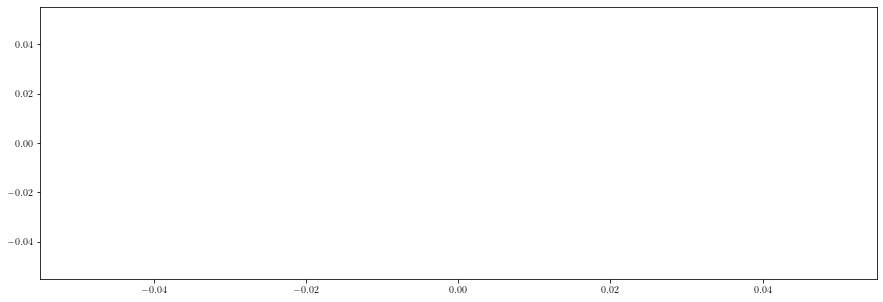

In [170]:
path="A.Dust_Ridge_sci.spw31.cube.I.pbcor.fits"
sc=SpectralCube.read(path)

vel,Dec,Ra = sc.world[:,0,0] 
z,x,y=pylab.where(sc.hdu.data==np.nanmax(sc.hdu.data))
subcube=sc.hdu.data[:,int(x)-10:int(x)+10,int(y)-10:int(y)+10]
spectrum = np.average(subcube,axis=(1,2)) 

#plot figure
fig1=pylab.figure(1,figsize=(15,5))
ax1=pylab.subplot()
ax1.plot(vel,spectrum,lw=1,drawstyle='steps-mid',color="Red")

## Croping num 4 down to r=100 pix

Text(0, 0.5, 'Intensity (Jy/beam)')

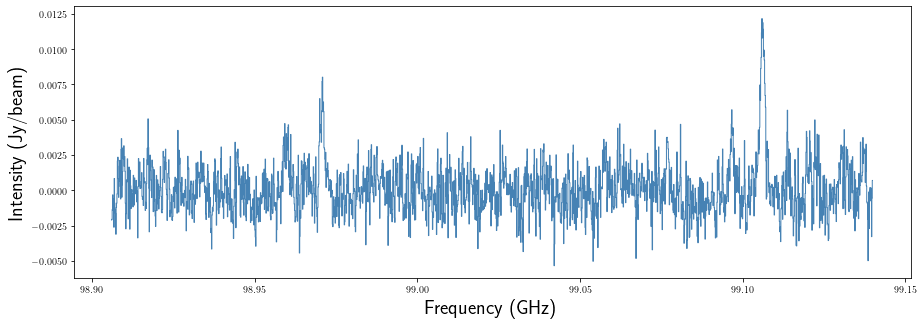

In [184]:
import regions
path="A.Dust_Ridge_sci.spw31.cube.I.pbcor.fits"
sc_hz=SpectralCube.read(path)
sc=sc_hz.with_spectral_unit(u.Hz*10**9)
freq,dec,ra=sc.world[:,0,0]

region_str = "circle[[144pix, 144pix], 100pix], ICRS" 
#cropped down to 100pix because full image wouldn't produce spectra since max was an
#edge case found using casa
region = regions.Regions.parse(region_str,format='crtf')
crop = sc.subcube_from_regions(region) 

z,x,y=pylab.where(crop.hdu.data==np.nanmax(crop.hdu.data))

subcube=crop.hdu.data[:,int(x)-10:int(x)+10,int(y)-10:int(y)+10]
spectrum = np.average(subcube,axis=(1,2)) 

#plot figure
fig1=pylab.figure(1,figsize=(15,5))
ax1=pylab.subplot()
ax1.plot(freq,spectrum,lw=1,drawstyle='steps-mid',color="SteelBlue")
pylab.xlabel("Frequency (GHz)", fontsize=20)
pylab.ylabel("Intensity (Jy/beam)", fontsize=20)




## Fixing cube 6 using same technique as 4

Text(0, 0.5, 'Intensity (Jy/beam)')

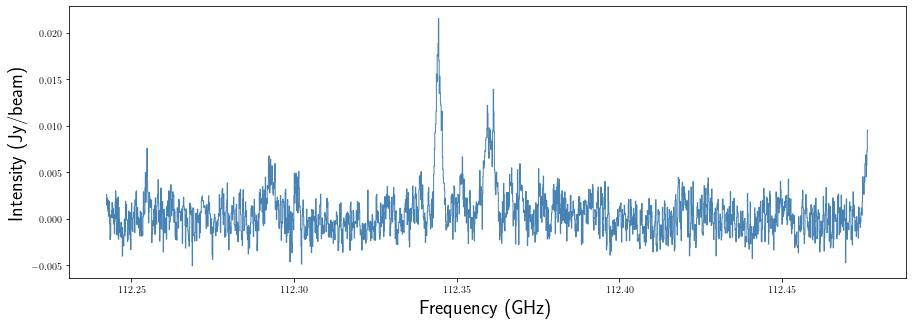

In [183]:
path="B.Dust_Ridge_12C17O.cube.I.pbcor.fits"
sc_hz=SpectralCube.read(path)
sc=sc_hz.with_spectral_unit(u.Hz*10**9)
freq,dec,ra=sc.world[:,0,0]

region_str = "circle[[175pix, 175pix], 100pix], ICRS" 
#cropped down to 100pix because full image wouldn't produce spectra since max was an
#edge case found using casa
region = regions.Regions.parse(region_str,format='crtf')
crop = sc.subcube_from_regions(region) 

z,x,y=pylab.where(crop.hdu.data==np.nanmax(crop.hdu.data))

subcube=crop.hdu.data[:,int(x)-10:int(x)+10,int(y)-10:int(y)+10]
spectrum = np.average(subcube,axis=(1,2)) 

#plot figure
fig1=pylab.figure(1,figsize=(15,5))
ax1=pylab.subplot()
ax1.plot(freq,spectrum,lw=1,drawstyle='steps-mid',color="SteelBlue")
pylab.xlabel("Frequency (GHz)", fontsize=20)
pylab.ylabel("Intensity (Jy/beam)", fontsize=20)




## Task 5